# CP1559 off-target analysis of Cas9-NG and SpG

Notebook adapated from PCD's "cp1559_off_target_analysis"-- AKS added in SpG data, generated CFD matrices irrespective of guide type and calculated on and off-target metrics

2021-05-12 updated lfc and pam list files 

In [79]:
import pandas as pd
import seaborn as sns
import gpplot 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy import stats
import random
from sklearn.metrics import auc
import warnings
import gpplot as gpplot
warnings.filterwarnings('ignore')

# Set default settings for plotting
sns.set_style('ticks')
sns.set_context('talk')
mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [80]:
lfc_df = pd.read_table('../../../data_v3/Fig 4_PAM flex off-targets/processed/PAMflex_off-target_CP1559_avglfc_v1.txt')
#spg_lfc_df = pd.read_excel('data/raw/2021-02-24_SpG CP1559 scores.xlsx', 'LFC')
meta_information = pd.read_csv('../../../data_v3/Fig 4_PAM flex off-targets/raw/vqr_ng_off_target_lib_v3.csv')
#cas9_hf_variant_cfd = pd.read_csv('data/processed/cas9_hfvars_cfd.csv')
#wt_cas9_cfd = pd.read_csv('data/external/cfd_2016.csv')
pam_activity = pd.read_table('../../../data_v3/Fig 1_3_PanPAM on-target/processed/fractionactive_allsgRNA_v1.txt')
pam_list_ng = pd.read_csv('../../../data_v3/pam_lists/2021-05-11_PAM list 4_v2.csv')
pam_list_spg = pd.read_csv('../../../data_v3/pam_lists/2021-05-11_PAM list 5_v2.csv')

## QC and Data Munging
First, we clean up some of the meta-information files, adding one to the mismatch position of G19 sgRNAs

In [81]:
#pams that are intermediate + active with BOTH SpG and NG 

pam_list = pd.merge(pam_list_ng, pam_list_spg, on='PAM', how='inner')
len(pam_list)

56

In [82]:
# pam_activity_filtered = (pam_activity[['PAM', 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;FractionActive', 'A375;AACW03;RDA_449;;21;;AVGLFC','N_PAM']]
#                        .rename({'A375_275;AACW03;M-AE70;Dropout;AVGLFC;FractionActive': 'Cas9-NG_PAM_activity',
#                                'A375;AACW03;RDA_449;;21;;AVGLFC': 'SpG_PAM_activity'}, axis=1))



In [83]:
def get_guide_type(row):
    if row['Length of WT Sequence'] == 19:
        return 'G19'
    elif row['G20_x'] == 'y':
        return 'G20'
    else:
        return 'g20'

def align_mismatch_pos(row):
    if row['Mismatch Position'] == 'none':
        mismatch = 'none'
    elif row['guide_type'] == 'G19':
        mismatch = ','.join([str(int(pos) + 1) for pos in row['Mismatch Position'].split(',')])
    else: 
        mismatch = row['Mismatch Position']
    return mismatch
    
meta_information['guide_type'] = meta_information.apply(lambda df: get_guide_type(df), axis=1)
breif_meta = (meta_information[['WT Sequence', 'Mismatch Sequence', 'Reference Sequence', 'Context_x', 
                                'N_PAM', 'PAM_x', 'Gene_x', 'guide_type', 'Number of mismatches', 'Mismatch Position',
                                'Type of Mismatch']]
              .rename({'Context_x': 'Context', 'PAM_x':'PAM', 'Gene_x': 'Gene'}, axis=1))
breif_meta['Mismatch Position'] = breif_meta.apply(align_mismatch_pos, axis=1)

In [84]:
lfc_df.head()

,Unnamed: 0,Construct Barcode,Construct IDs,A375_CP1559_RDA449_Rep A,A375_CP1559_RDA449_Rep B,A375_CP1559_RDA275_Rep A,A375_CP1559_RDA275_Rep B,A375_CP1559_RDA449_AVGLFC_frompDNA,A375_CP1559_RDA275_AVGLFC_frompDNA
0,0,AACAACATGCGGGTGATGAG,EEF2,-2.156974,-1.291767,-2.417786,-2.561979,-1.724371,-2.489882
1,1,TACAACATGCGGGTGATGAG,EEF2,-3.778811,-4.076727,-2.828993,-3.659679,-3.927769,-3.244336
2,2,GACAACATGCGGGTGATGAG,EEF2,-2.588589,-2.504549,-2.550533,-1.569272,-2.546569,-2.059902
3,3,CTCAACATGCGGGTGATGAG,EEF2,-3.282269,-3.041032,-2.995083,-2.547892,-3.161650,-2.771488
4,4,CCCAACATGCGGGTGATGAG,EEF2,-3.352985,-2.771459,-3.667303,-3.111651,-3.062222,-3.389477


In [85]:
lfc_meta = (lfc_df.rename({'A375_CP1559_RDA275_Rep A': 'NG Rep_A', 
                           'A375_CP1559_RDA275_Rep B': 'NG Rep_B', 
                           'A375_CP1559_RDA275_AVGLFC_frompDNA': 'NG avg_lfc', 
                          'A375_CP1559_RDA449_Rep A' : 'SpG Rep_A',
                          'A375_CP1559_RDA449_Rep B' : 'SpG Rep_B',
                          'A375_CP1559_RDA449_AVGLFC_frompDNA' : 'SpG avg_lfc'},axis=1).merge(breif_meta, left_on='Construct Barcode', right_on='Reference Sequence', how='inner'))

We see a strong correlation between replicates

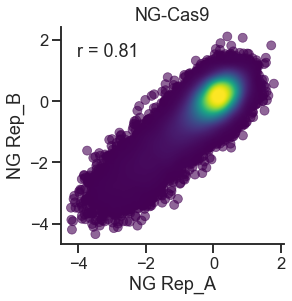

In [86]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_meta, x='NG Rep_A', y='NG Rep_B')
gpplot.add_correlation(data=lfc_meta, x='NG Rep_A', y='NG Rep_B')
plt.title('NG-Cas9')
sns.despine()

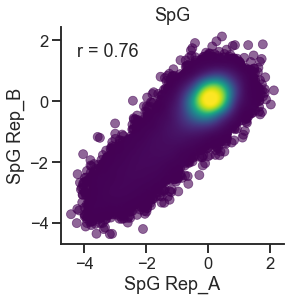

In [87]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_meta, x='SpG Rep_A', y='SpG Rep_B')
gpplot.add_correlation(data=lfc_meta, x='SpG Rep_A', y='SpG Rep_B')
plt.title('SpG')
sns.despine()

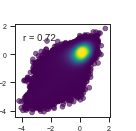

In [88]:
gpp.set_aesthetics(context='paper')

plt.subplots(figsize=(1.7,1.7))
gpplot.point_densityplot(data=lfc_meta, x='NG avg_lfc', y='SpG avg_lfc')
gpplot.add_correlation(data=lfc_meta, x='NG avg_lfc', y='SpG avg_lfc')
plt.xlabel('Cas9-NG Avg LFC', fontsize=7)
plt.ylabel('SpG Avg LFC', fontsize=7)
plt.tick_params(axis='both', labelsize=7)
plt.savefig('../../../Figures/panels/Fig 4/ng_spg_offtarget_scatter.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [89]:
print(len(lfc_meta))

78058


## Summarizing input data

In [90]:
lfc_meta['Number of mismatches'].value_counts()

double     59202
single     17569
Control      989
none         298
Name: Number of mismatches, dtype: int64

About 1/2 of sgRNAs are g20, 1/4 G19 and 1/4 G20

In [91]:
lfc_meta['guide_type'].value_counts()

g20    46148
G19    17755
G20    14155
Name: guide_type, dtype: int64

In [92]:
lfc_meta['PAM'].value_counts()

GGGT    1820
AGTG    1769
TGCG    1622
AGCG    1583
GGAG    1566
        ... 
ATGC     226
GTCC     226
AGTA     223
TACT     220
TCCT      98
Name: PAM, Length: 157, dtype: int64

## Calculating the probability that each guide is active

The perfect match guides are slightly less active than we might expect, so, we'll filter for guides with more acitivity, included in the PAM list 3 for Cas9 variants

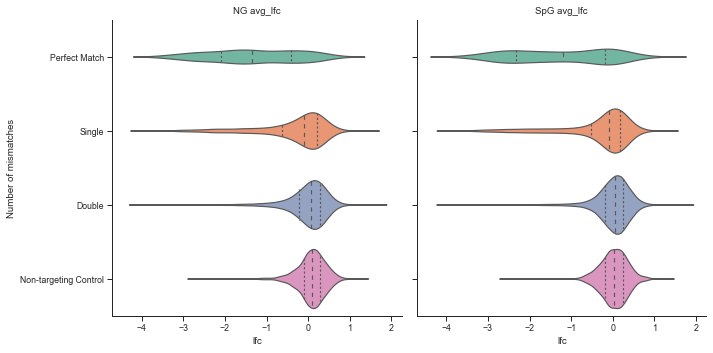

In [93]:
long_lfcs = (lfc_meta.melt(id_vars=['Construct Barcode', 'Construct IDs',
                                         'WT Sequence', 'Reference Sequence',
                                         'PAM', 'Number of mismatches', 'guide_type',
                                         'Type of Mismatch', 'Mismatch Position'],
                                value_vars=['NG avg_lfc',
                                            'SpG avg_lfc'],
                                var_name='condition', value_name='lfc')
             .rename({'Construct IDs': 'Target ID'}, axis=1))
#long_lfcs['condition'] = long_lfcs['condition'].replace({'A375;CP1520;RDA_085;;21;;AVGLFC': 'WTCas9',
                                                         #'A375;CP1520;RDA_152;;21;;AVGLFC': 'eCas9-1.1',
                                                         #'A375;CP1520;RDA_381;;21;;AVGLFC': 'HiFi-Cas9'})
long_lfcs['Number of mismatches'] = long_lfcs['Number of mismatches'].replace({'none' : 'Perfect Match',
                                                                              'single' : 'Single',
                                                                              'double': 'Double',
                                                                              'Control': 'Non-targeting Control'})
long_lfcs['Number of mismatches'] = pd.Categorical(long_lfcs['Number of mismatches'], 
                                                   categories=['Perfect Match', 'Single', 'Double', 'Non-targeting Control'])
g = sns.catplot(y='Number of mismatches', x='lfc',
                col="condition",
                data=long_lfcs,
                orient="h", palette="Set2",
                kind="violin", inner='quartile')
g.set_titles("{col_name}")
#plt.savefig('HF-variants_offtarget_v2.pdf', dpi = 1000, bbox_inches='tight')

In [94]:
color_dictionary = dict({'Non-targeting Control':'#8da0cb',
                  'Double':'#fc8d62',
                  'Single': '#66c2a5',
                  'Perfect Match': '#e78ac3'})

In [95]:
spg_long = long_lfcs[long_lfcs['condition'] == 'SpG avg_lfc']


Text(0.5, 0.98, 'SpG')

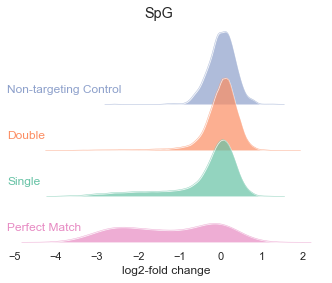

In [96]:
#with all PAMs
g = gpplot.ridgeplot(spg_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('SpG')
#plt.savefig('../../../Figures/panels/Fig 4/SpG_ridge_entire_lib.pdf', bbox_inches ='tight', dpi = 1000, transparent='True')

In [97]:
ng_long = long_lfcs[long_lfcs['condition'] == 'NG avg_lfc']


Text(0.5, 0.98, 'Cas9-NG')

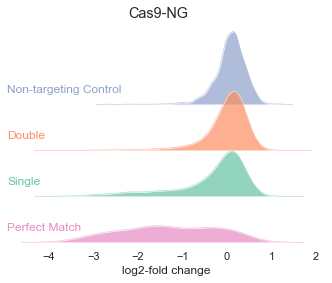

In [98]:
#with all PAMs
g = gpplot.ridgeplot(ng_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('Cas9-NG')
#plt.savefig('../../../Figures/panels/Fig 4/NG_ridge_entire_lib.pdf', bbox_inches ='tight', dpi = 1000, transparent='True')

In [99]:
filt = 'shared_pams'
if filt == 'shared_pams':
    filtered_lfcs = lfc_meta[lfc_meta['PAM'].isna() | lfc_meta['PAM'].isin(pam_list['PAM'])].copy() # Controls are NA
elif filt == 'top_wt_sgs':
    wt_sgs = lfc_meta[lfc_meta['Number of mismatches'] == 'none']
    top18_wt_sgs = wt_sgs[(wt_sgs
                           .groupby(['guide_type'])
                           ['avg_lfc']
                           .rank() <= 18)]
    filtered_lfcs = lfc_meta[lfc_meta['PAM'].isna() | lfc_meta['WT Sequence'].isin(top18_wt_sgs['WT Sequence'])].copy() # Controls are NA

In [100]:
filtered_lfcs['Number of mismatches'].value_counts()

double     29877
single      8809
Control      989
none         149
Name: Number of mismatches, dtype: int64

In [101]:
filt = 'shared_pams'
if filt == 'shared_pams':
    filtered_long_lfcs = long_lfcs[long_lfcs['PAM'].isna() | long_lfcs['PAM'].isin(pam_list['PAM'])].copy() # Controls are NA
elif filt == 'top_wt_sgs':
    wt_sgs = long_lfcs[long_lfcs['Number of mismatches'] == 'none']
    top18_wt_sgs = wt_sgs[(wt_sgs
                           .groupby(['guide_type'])
                           ['avg_lfc']
                           .rank() <= 18)]
    filtered_long_lfcs = long_lfcs[long_lfcs['PAM'].isna() | long_lfcs['WT Sequence'].isin(top18_wt_sgs['WT Sequence'])].copy() # Controls are NA

When we filter for the most active PAMs, we see a greater separation between perfect matches and controls

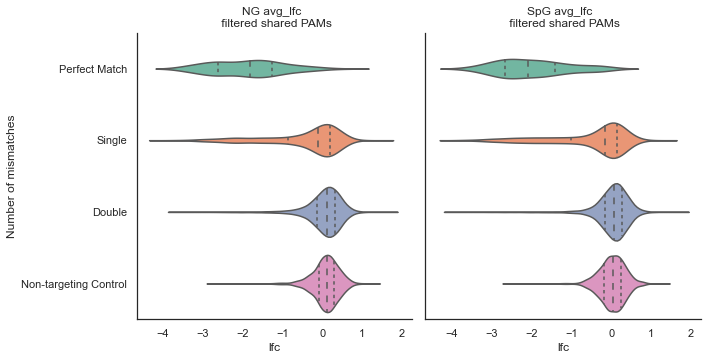

In [102]:
g = sns.catplot(y='Number of mismatches', x='lfc',
                col="condition",
                data=filtered_long_lfcs,
                orient="h", palette="Set2",
                kind="violin", inner='quartile')
g.set_titles("{col_name}  \n filtered shared PAMs")
#plt.savefig('SpG_NG_violin_shared_PAMs.pdf')

In [103]:
color_dictionary = dict({'Non-targeting Control':'#8da0cb',
                  'Double':'#fc8d62',
                  'Single': '#66c2a5',
                  'Perfect Match': '#e78ac3'})

In [104]:
spg_filtered = filtered_long_lfcs[filtered_long_lfcs['condition'] == 'SpG avg_lfc']


Text(0.5, 0.98, 'SpG')

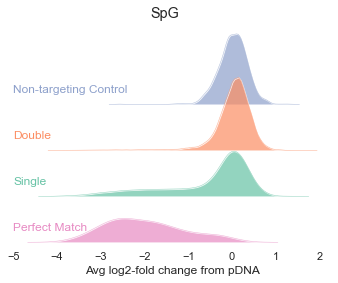

In [105]:
#with shared PAMs
g = gpplot.ridgeplot(spg_filtered, 'lfc', 'Number of mismatches', palette=color_dictionary,
                    row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('Avg log2-fold change from pDNA')
plt.suptitle('SpG')
#plt.savefig('../../../Figures/panels/Fig 4/SpG_ridge_filtered.pdf', bbox_inches ='tight', dpi = 1000, transparent = True)

In [106]:
ng_filtered = filtered_long_lfcs[filtered_long_lfcs['condition'] == 'NG avg_lfc']


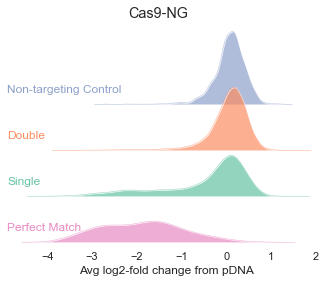

In [107]:
g = gpplot.ridgeplot(ng_filtered, 'lfc', 'Number of mismatches', palette=color_dictionary,
                    row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
plt.xlabel('Avg log2-fold change from pDNA')
plt.suptitle('Cas9-NG')
g.fig.subplots_adjust(hspace=-.4)
#plt.savefig('../../../Figures/panels/Fig 4/NG_ridge.pdf', bbox_inches ='tight', dpi = 1000, transparent=True)

In [108]:
def build_logistic_model(data, activity_col, category_col, active_category):
    model = LogisticRegression(random_state=7)
    X = data[[activity_col]]
    y = data[category_col] == active_category
    model.fit(X, y)
    return model

def get_probability_active(data, activity_col, category_col, active_category, inactive_category):
    model_matrix = data[data[category_col].isin([active_category, inactive_category])]
    model = build_logistic_model(model_matrix, activity_col, category_col, active_category)
    data['active_probability'] = model.predict_proba(data[[activity_col]])[:,1] # 1 == active
    return data
    
active_probability_df =  get_probability_active(filtered_long_lfcs, 'lfc', 'Number of mismatches', 'Perfect Match', 'Non-targeting Control')



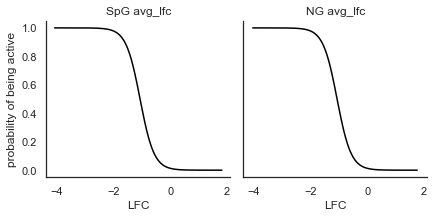

In [109]:
g = sns.FacetGrid(active_probability_df.sort_values('lfc'), col='condition')
g.map_dataframe(sns.lineplot, x='lfc', y='active_probability', estimator=None, color='black')
g.set_titles("{col_name}")
g.set_axis_labels("LFC", "probability of being active")
#g.set_xticklabels([-5, 0])

#plt.savefig('prob_active_ng_spg.pdf', dpi=1000, bbox_inches='tight')

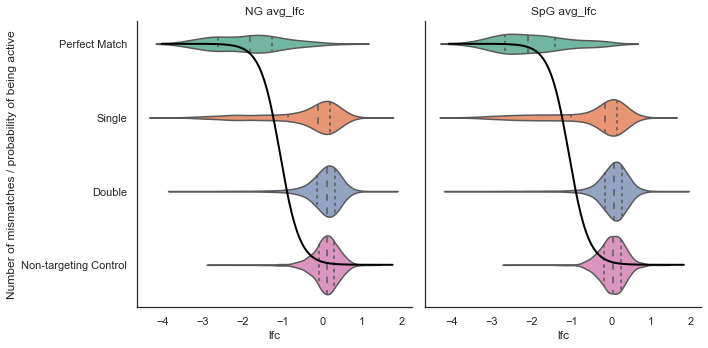

In [110]:
g = sns.catplot(y='Number of mismatches', x='lfc',
                col="condition",
                data=filtered_long_lfcs,
                orient="h", palette="Set2",
                kind="violin", inner='quartile')
g.set_titles("{col_name}")
g.set_axis_labels("lfc", "Number of mismatches / probability of being active")

axes = g.axes[0]
for ax in axes:
    condition = ax.title.get_text()
    condition_probability = active_probability_df[active_probability_df['condition'] == condition].sort_values('lfc')
    ax.plot(condition_probability['lfc'], (1-condition_probability['active_probability'])*3, color='black', lw=2)
    
#plt.savefig('prob_active_ng_spg_violin.pdf', dpi=1000, bbox_inches='tight')    

## Comparing Active Probabilities Across Different Subsets

We see about 2/3 of PAMs agree on CFD scores, with a smaller subset standing out as outliers

In [111]:
def compare_off_target_probabilities(active_probability_df, condition):
    print(condition)
    condition_probabilities = active_probability_df[(active_probability_df.condition == condition) &
                                                    (active_probability_df['Number of mismatches'] == 'Single')]

    # PAM
    spread_probabilities_pam = condition_probabilities.pivot_table(index=['Type of Mismatch', 'Mismatch Position'],
                                                                   columns=['PAM'], values='active_probability')
    prob_cor_pam = spread_probabilities_pam.corr()
    cors_pam = prob_cor_pam.values
    print('PAM mean r: ' + str(np.mean(cors_pam[cors_pam!=1])))
    sns.clustermap(spread_probabilities_pam.corr(), vmin=-1, vmax=1, center=0, cmap='RdBu_r', 
                   figsize=(15,15))
    plt.title(condition)


NG avg_lfc
PAM mean r: 0.32908992303986145


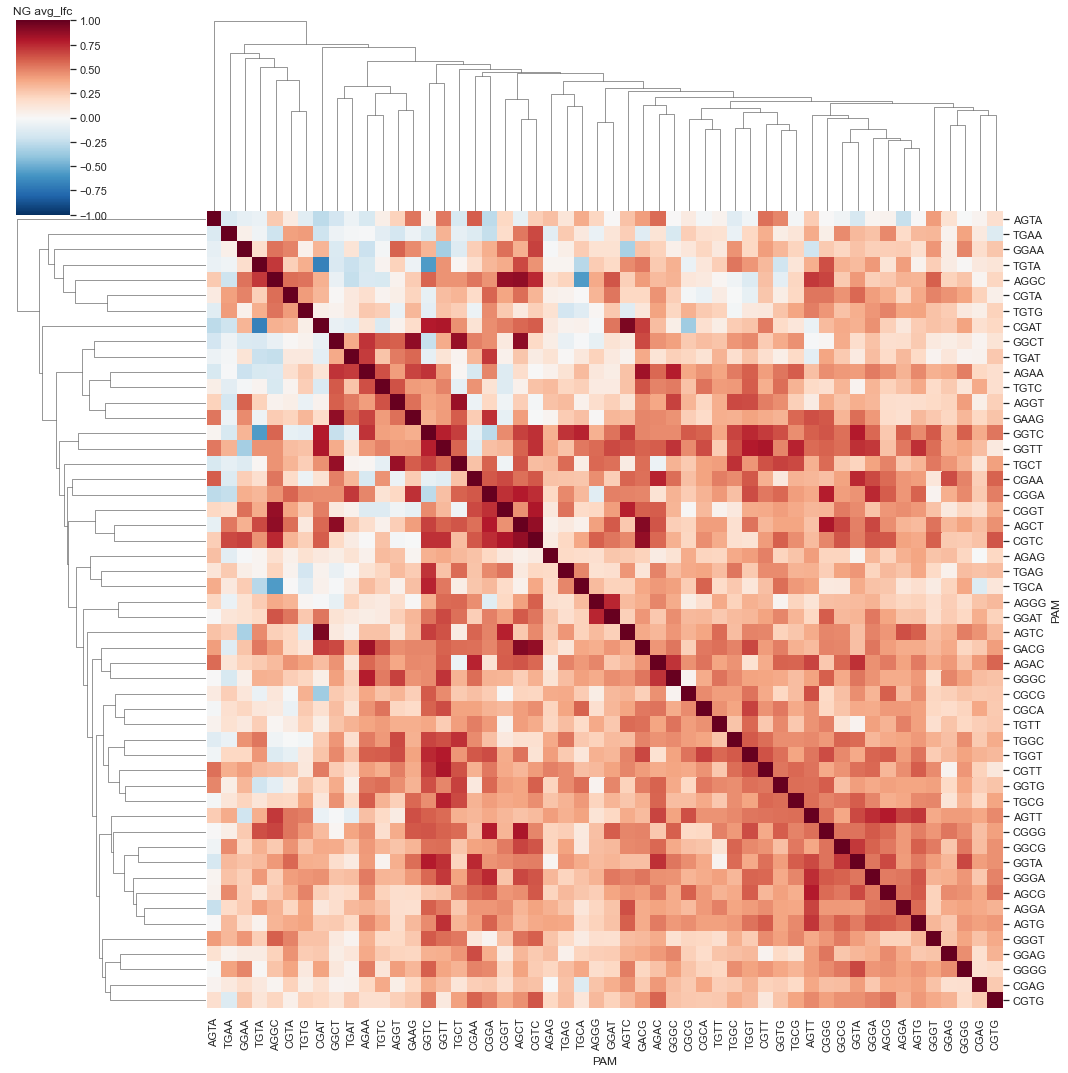

In [112]:
compare_off_target_probabilities(active_probability_df, 'NG avg_lfc')

SpG avg_lfc
PAM mean r: 0.3431183134026917


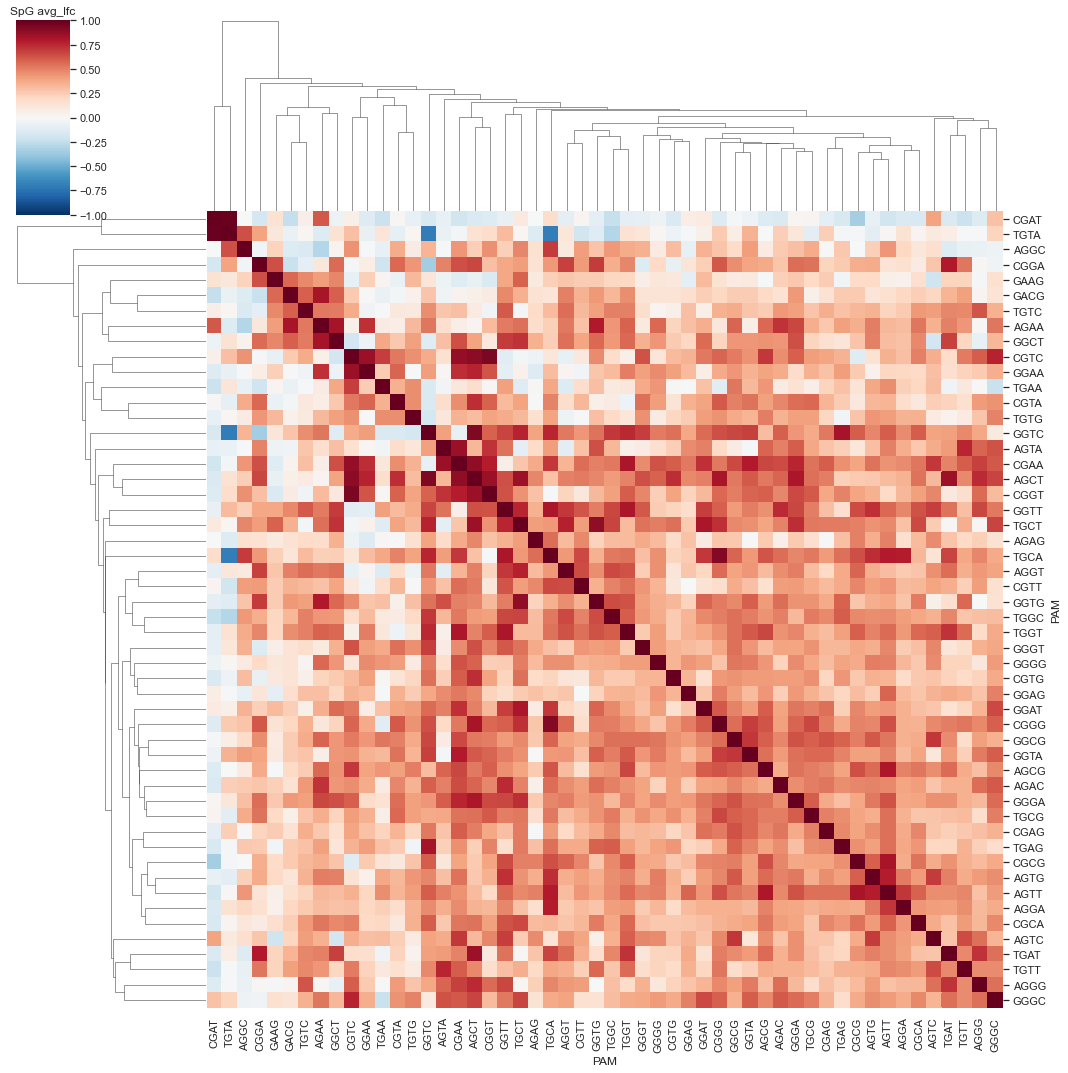

In [113]:
compare_off_target_probabilities(active_probability_df, 'SpG avg_lfc')

These PAMs vary in their activites, suggesting it's not an effect of PAM activity

In [114]:
# #PCD had previsouly filtered all but CATG, GATG, TGTA PAMs out based on NG's activity.
# #AKS also filtered out the others based on SpG's activity
# if filt == 'shared_pams':
#     outlier_pams = ['CGAT', 'GGAA', 'AGGC', 'TGTA', 'AGTA', 
#                     'AGGG', 'AGAG', 'GAGG', 'CGGT', 'GAGT', 
#                     'GGGT', 'CGTA', 'TGTG', 'TGCA', 'GAGA', 
#                     'TGAA', 'CATG', 'GATG', 'TGTA']
#     pam_activity[pam_activity['PAM'].isin(outlier_pams)]

In [115]:
single_mismatch_df = active_probability_df[active_probability_df['Number of mismatches'] == 'Single'].copy()

Similarly, there's a relatively even distribution of g20, G19 and G20 sgRNAs

In [116]:
# if filt == 'shared_pams':
#     pam_outlier_guide_dist = single_mismatch_df.loc[single_mismatch_df.PAM.isin(outlier_pams), 'guide_type'].value_counts()
#     pam_outlier_guide_dist/sum(pam_outlier_guide_dist)

In [117]:
# if filt == 'shared_pams':
#     pam_non_outlier_guide_dist = single_mismatch_df.loc[~single_mismatch_df.PAM.isin(outlier_pams), 'guide_type'].value_counts()
#     pam_non_outlier_guide_dist/sum(pam_non_outlier_guide_dist)

This could suggest that there are interactions between mismatches PAM sequence

## Comparing CFD matrices

First we plot the CFD matrices

Text(0.5, 1.0, 'Cas9-NG G19')

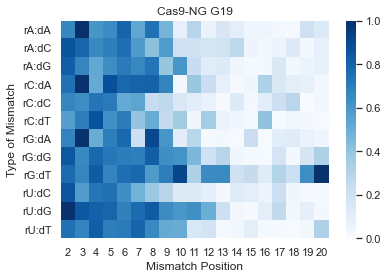

In [118]:
G19_cfd_ng = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G19') & 
                              (single_mismatch_df['condition'] =='NG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G19_cfd_ng['Mismatch Position'] = G19_cfd_ng['Mismatch Position'].astype(int)
G19_cfd_matrix = G19_cfd_ng.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                    columns='Mismatch Position')
sns.heatmap(G19_cfd_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('Cas9-NG G19')
#plt.savefig('../../../Figures/panels/Fig 4/Cas9-NG G19_v2.pdf', bbox_inches='tight', dpi=1000, transparent =True)

Text(0.5, 1.0, 'SpG G19')

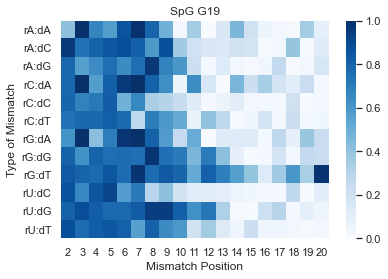

In [119]:
G19_cfd_spg = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G19') & 
                              (single_mismatch_df['condition'] =='SpG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G19_cfd_spg['Mismatch Position'] = G19_cfd_spg['Mismatch Position'].astype(int)
G19_cfd_matrix = G19_cfd_spg.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                    columns='Mismatch Position')
sns.heatmap(G19_cfd_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('SpG G19')
#plt.savefig('../../../Figures/panels/Fig 4/SpG G19_v2.pdf', bbox_inches='tight', dpi=1000, transparent=True)

Text(0.5, 1.0, 'Cas9-NG g20')

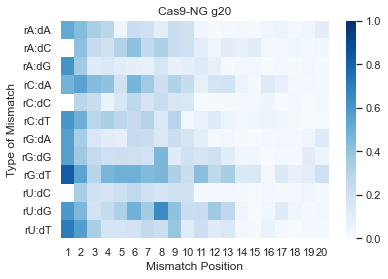

In [120]:
g20_cfd_ng = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'g20') & 
                              (single_mismatch_df['condition'] =='NG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
g20_cfd_ng['Mismatch Position'] = g20_cfd_ng['Mismatch Position'].astype(int)
g20_cfd_matrix = g20_cfd_ng.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(g20_cfd_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('Cas9-NG g20')
#plt.savefig('../../../Figures/panels/Fig 4/NG g20.pdf', bbox_inches='tight', dpi=1000, transparent=True)

Text(0.5, 1.0, 'SpG g20')

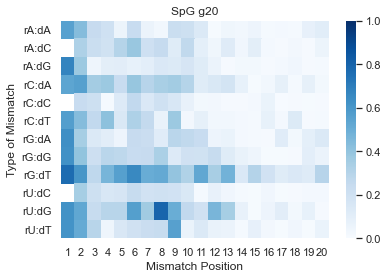

In [121]:
g20_cfd_spg = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'g20') & 
                              (single_mismatch_df['condition'] =='SpG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
g20_cfd_spg['Mismatch Position'] = g20_cfd_spg['Mismatch Position'].astype(int)
g20_cfd_matrix = g20_cfd_spg.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(g20_cfd_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('SpG g20')
#plt.savefig('../../../Figures/panels/Fig 4/SpG g20.pdf', bbox_inches='tight', dpi=1000, transparent=True)

Text(0.5, 1.0, 'Cas9-NG G20')

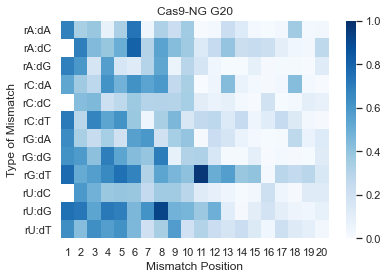

In [122]:
G20_cfd_ng = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G20') &
                             (single_mismatch_df['condition'] =='NG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G20_cfd_ng['Mismatch Position'] = G20_cfd_ng['Mismatch Position'].astype(int)
G20_cfd_matrix = G20_cfd_ng.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(G20_cfd_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('Cas9-NG G20')
#plt.savefig('../../../Figures/panels/Fig 4/NG G20.pdf', bbox_inches='tight', dpi=1000, transparent=True)

Text(0.5, 1.0, 'SpG G20')

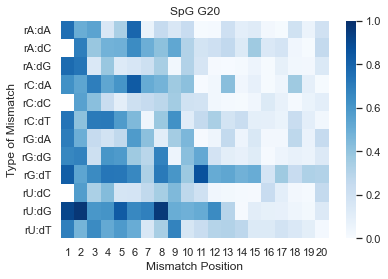

In [123]:
G20_cfd_spg = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G20') &
                             (single_mismatch_df['condition'] =='SpG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G20_cfd_spg['Mismatch Position'] = G20_cfd_spg['Mismatch Position'].astype(int)
G20_cfd_matrix = G20_cfd_spg.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(G20_cfd_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('SpG G20')
#plt.savefig('../../../Figures/panels/Fig 4/SpG G20.pdf', bbox_inches='tight', dpi=1000, transparent=True)

Note that there are no wildtype g20 and G20 guides with a G in the first position, so the rN:dC squares are blank

In [124]:
((single_mismatch_df['WT Sequence'].str[0] == 'G') &
 (single_mismatch_df['guide_type'].isin(['g20', 'G20']))).sum()

0

In [134]:
def add_xy_line(slope=1, intercept=0, ax=None, linestyle='dashed', linecolor='black', xlim=None):
    """Add line with specified slope and intercept to a scatter plot; Default: y=x line
    Parameters
    ----------
    slope: float
        Value of slope of line to be drawn
    intercept: float
        Value of intercept of line to be drawn
    ax: Axis object, optional
        Plot to add line to
    linestyle: str, optional
        Style of line
    linecolor: str, optional
        Color of line
    Returns
    -------
    matplotlib.axes.Axes
    """
    if ax is None:
        ax = plt.gca()
    if xlim is None:
        xlim = ax.get_xlim()
    x = np.array(xlim)
    y = intercept + slope * x
    ax = ax.plot(x, y, linestyle=linestyle, color=linecolor)
    return ax

def scatter_comparison(data, x, y, ax, hue='Mismatch Position', palette='viridis', legend=False):
    sns.scatterplot(data=data, x=x, y=y,hue=hue, palette=palette, ax=ax, legend=legend, linewidth=0)
    #ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    gpplot.add_correlation(data=data.dropna(), x=x, y=y, ax=ax, loc='lower right')
    sns.despine()
    add_xy_line(ax=ax, xlim=(0,1))

In [127]:
spread_probabilities_g_status = (single_mismatch_df.pivot_table(index=['Type of Mismatch', 'Mismatch Position', 'condition'],
                                                                columns=['guide_type'], values='active_probability')
                                 .reset_index())
spread_probabilities_g_status['Mismatch Position'] = spread_probabilities_g_status['Mismatch Position'].astype(int)

In [128]:
spread_probabilities_g_status

guide_type,Type of Mismatch,Mismatch Position,condition,G19,G20,g20
0,rA:dA,1,NG avg_lfc,NaN,0.687918,0.521596
1,rA:dA,1,SpG avg_lfc,NaN,0.761352,0.557962
2,rA:dA,10,NG avg_lfc,0.085806,0.369401,0.195888
3,rA:dA,10,SpG avg_lfc,0.034284,0.241498,0.212598
4,rA:dA,11,NG avg_lfc,0.300543,0.005014,0.037007
...,...,...,...,...,...,...
469,rU:dT,7,SpG avg_lfc,0.560146,0.159514,0.232499
470,rU:dT,8,NG avg_lfc,0.657962,0.346506,0.221827
471,rU:dT,8,SpG avg_lfc,0.811045,0.344630,0.242712
472,rU:dT,9,NG avg_lfc,0.516109,0.580785,0.392773


When we plot each square in the CFD matrix as a point, representing the position of the mismatch by color, we see that g20 guides are least the promiscuous followed by G20 and then G19

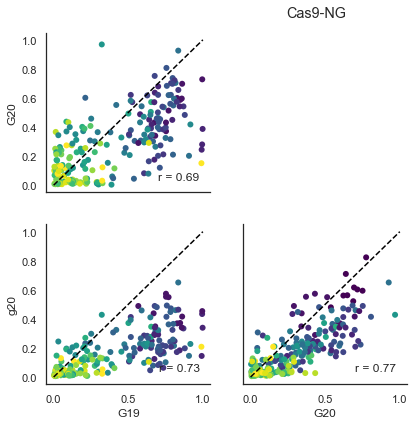

In [136]:
ng = spread_probabilities_g_status[spread_probabilities_g_status['condition'] == 'NG avg_lfc']
conditions = ['G19', 'G20', 'g20']
fig, axs = plt.subplots(nrows=len(conditions), ncols=len(conditions), figsize=(10,10), sharex=True, sharey=True)
for i in range(len(conditions)):
    for j in range(len(conditions)):
        ax = axs[i, j]
        if i > j:
            x = conditions[i]
            y = conditions[j]  
            scatter_comparison(ng, y, x, ax)
        else:
            ax.remove()
fig.suptitle('Cas9-NG', y=0.65)
plt.savefig('../../../Figures/panels/Fig 4/NG CFD by 5type scatter.pdf', bbox_inches='tight', dpi=1000, transparent=True)

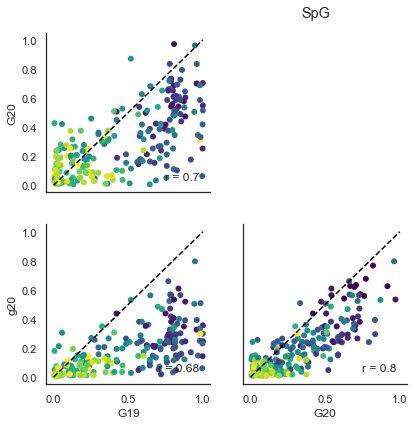

In [135]:
spg = spread_probabilities_g_status[spread_probabilities_g_status['condition'] == 'SpG avg_lfc']
conditions = ['G19', 'G20', 'g20']
fig, axs = plt.subplots(nrows=len(conditions), ncols=len(conditions), figsize=(10,10), sharex=True, sharey=True)
for i in range(len(conditions)):
    for j in range(len(conditions)):
        ax = axs[i, j]
        if i > j:
            x = conditions[i]
            y = conditions[j]  
            scatter_comparison(spg, y, x, ax)
        else:
            ax.remove()
fig.suptitle('SpG', y=0.65)
plt.savefig('../../../Figures/panels/Fig 4/SpG CFD by 5type scatter.pdf', bbox_inches='tight', dpi=1000, transparent=True)

We can expand this comparison to the high fidelity Cas9 variants, and surprisingly, for the g20 and G20 variants, thes enzymes are less promiscuous than the high fidelity variants

In [54]:
single_mismatch_active_probability = (active_probability_df[active_probability_df['Number of mismatches'] == 'Single']
                                      .groupby(['Type of Mismatch', 'Mismatch Position', 'condition'])
                                      .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                      .reset_index())
single_mismatch_active_probability['Mismatch Position'] = single_mismatch_active_probability['Mismatch Position'].astype(int)
spread_single_mismatch = (single_mismatch_active_probability.pivot_table(values='avg_active_prob_single', 
                                                                         index=['Type of Mismatch', 'Mismatch Position'], 
                                                                         columns=['condition'])
                          .reset_index())
spread_single_mismatch['Mismatch Position'] = spread_single_mismatch['Mismatch Position'].astype('int')

In [55]:
spread_single_mismatch = spread_single_mismatch.rename(columns = {'NG avg_lfc' : 'Cas9-NG',
                                                       'SpG avg_lfc': 'SpG'})


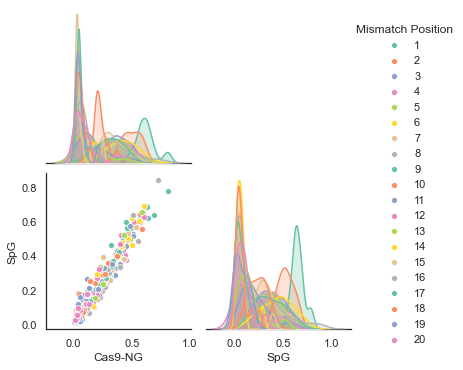

In [56]:
g = sns.pairplot(spread_single_mismatch, hue='Mismatch Position',  
                 corner=True, palette='Set2', aspect=1, diag_kind='kde', 
                 diag_kws={'clip': (0.0, 1.0)})
plt.savefig('../../../Figures/panels/Fig 4/Mismatch position comparison.pdf', bbox_inches = 'tight', dpi=1000, transparent=True)

In [57]:
gpp.set_aesthetics(context= 'paper', palette='Set2')

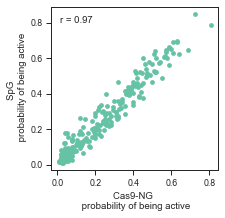

In [79]:
gpp.set_aesthetics(context='paper')
sns.scatterplot(data=spread_single_mismatch, x="Cas9-NG", y="SpG", linewidth=0)
gpp.add_correlation(data=spread_single_mismatch, x="Cas9-NG", y="SpG")
sns.set(rc={'figure.figsize':(3,3)})
plt.xlabel('Cas9-NG \n probability of being active')
plt.ylabel('SpG \n probability of being active')
plt.savefig('../../../Figures/panels/Fig 4/SpG NG CFD comparison_v2.pdf', dpi=1000, bbox_inches='tight', transparent=True)

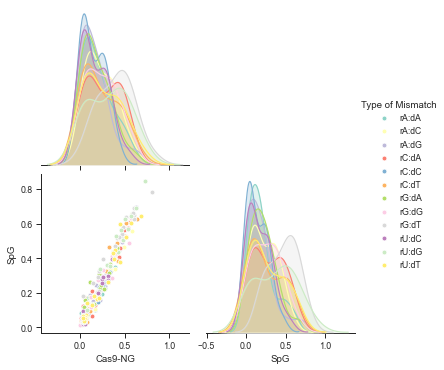

In [59]:
gpp.set_aesthetics(context='paper')
g = sns.pairplot(spread_single_mismatch.drop('Mismatch Position', axis=1), hue='Type of Mismatch',  
                 corner=True, palette='Set3', aspect=1, diag_kind='kde', 
                 diag_kws={'clip': (0.0, 1.0)})
#plt.savefig('mismatch_type comparison.pdf', dpi=1000, bbox_inches='tight', transparent=True)

## Data Outputs

In [60]:
G20_cfd_ng['condition'] = 'Cas9-NG_G20'
G19_cfd_ng['condition'] = 'Cas9-NG_G19'
g20_cfd_ng['condition'] = 'Cas9-NG_g20'
ng_output_df = (pd.concat([G20_cfd_ng, G19_cfd_ng, g20_cfd_ng])
             .sort_values(['condition', 'Mismatch Position', 'Type of Mismatch'])
             .rename({'avg_active_prob_single': 'prob_active'}, axis=1))

In [62]:
ng_output_df.to_csv('../../../data_v3/Fig 4_PAM flex off-targets/processed/cas9NG_cfd_v2.csv', index=False)

In [63]:
ng_output_df.head(13)

,Type of Mismatch,Mismatch Position,prob_active,condition
10,rA:dA,2,0.669982,Cas9-NG_G19
29,rA:dC,2,0.861191,Cas9-NG_G19
48,rA:dG,2,0.827681,Cas9-NG_G19
67,rC:dA,2,0.753106,Cas9-NG_G19
86,rC:dC,2,0.675605,Cas9-NG_G19
105,rC:dT,2,0.567418,Cas9-NG_G19
124,rG:dA,2,0.680923,Cas9-NG_G19
143,rG:dG,2,0.847696,Cas9-NG_G19
162,rG:dT,2,0.770123,Cas9-NG_G19
181,rU:dC,2,0.858592,Cas9-NG_G19


In [64]:
G20_cfd_spg['condition'] = 'Cas9-SpG_G20'
G19_cfd_spg['condition'] = 'Cas9-SpG_G19'
g20_cfd_spg['condition'] = 'Cas9-SpG_g20'
spg_output_df = (pd.concat([G20_cfd_spg, G19_cfd_spg, g20_cfd_spg])
             .sort_values(['condition', 'Mismatch Position', 'Type of Mismatch'])
             .rename({'avg_active_prob_single': 'prob_active'}, axis=1))

In [65]:
spg_output_df.to_csv('../../../data_v3/Fig 4_PAM flex off-targets/processed/cas9-spg_cfd_v2.csv', index=False)

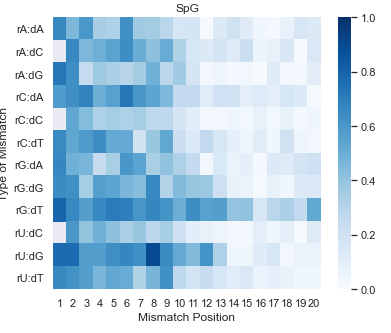

In [83]:
gpp.set_aesthetics(context='paper')
sns.set(rc={'figure.figsize':(6,5)})
spg_output_df['Mismatch Position'] = spg_output_df['Mismatch Position'].astype(int)
spg_output_matrix = spg_output_df.pivot_table(values='prob_active', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(spg_output_matrix, cmap='Blues', vmin=0, vmax=1)

plt.title('SpG')
plt.savefig('../../../Figures/panels/Fig 4/SpG_CFD_allsgrna_v2.pdf', dpi = 1000, bbox_inches = 'tight', transparent = True)

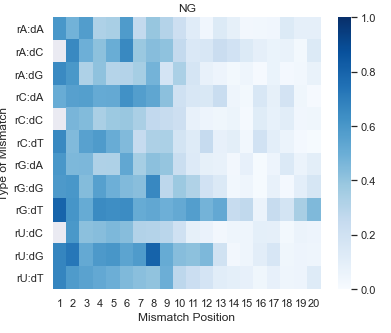

In [84]:
gpp.set_aesthetics(context='paper')
sns.set(rc={'figure.figsize':(6,5)})
ng_output_df['Mismatch Position'] = ng_output_df['Mismatch Position'].astype(int)
ng_output_matrix = ng_output_df.pivot_table(values='prob_active', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(ng_output_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('NG')
plt.savefig('../../../Figures/panels/Fig 4/NG_CFD_allsgrna_v2.pdf', dpi = 1000, bbox_inches = 'tight', transparent = True)

# Metric for comparing on and off-target activity

On-target activity: perfect match guides vs controls

Off-target: perfect match vs single or double

## On-targets 

In [85]:
filtered_lfcs

,Unnamed: 0,Construct Barcode,Construct IDs,SpG Rep_A,SpG Rep_B,NG Rep_A,NG Rep_B,SpG avg_lfc,NG avg_lfc,WT Sequence,Mismatch Sequence,Reference Sequence,Context,N_PAM,PAM,Gene,guide_type,Number of mismatches,Mismatch Position,Type of Mismatch
0,0,AACAACATGCGGGTGATGAG,EEF2,-2.156974,-1.291767,-2.417786,-2.561979,-1.724371,-2.489882,CACAACATGCGGGTGATGA,AACAACATGCGGGTGATGA,AACAACATGCGGGTGATGAG,ACGCGCACAACATGCGGGTGATGAAGTTCAG,NGTN,AGTT,EEF2,G19,single,2,rA:dG
1,1,TACAACATGCGGGTGATGAG,EEF2,-3.778811,-4.076727,-2.828993,-3.659679,-3.927769,-3.244336,CACAACATGCGGGTGATGA,TACAACATGCGGGTGATGA,TACAACATGCGGGTGATGAG,ACGCGCACAACATGCGGGTGATGAAGTTCAG,NGTN,AGTT,EEF2,G19,single,2,rU:dG
2,2,GACAACATGCGGGTGATGAG,EEF2,-2.588589,-2.504549,-2.550533,-1.569272,-2.546569,-2.059902,CACAACATGCGGGTGATGA,GACAACATGCGGGTGATGA,GACAACATGCGGGTGATGAG,ACGCGCACAACATGCGGGTGATGAAGTTCAG,NGTN,AGTT,EEF2,G19,single,2,rG:dG
3,3,CTCAACATGCGGGTGATGAG,EEF2,-3.282269,-3.041032,-2.995083,-2.547892,-3.161650,-2.771488,CACAACATGCGGGTGATGA,CTCAACATGCGGGTGATGA,CTCAACATGCGGGTGATGAG,ACGCGCACAACATGCGGGTGATGAAGTTCAG,NGTN,AGTT,EEF2,G19,single,3,rU:dT
4,4,CCCAACATGCGGGTGATGAG,EEF2,-3.352985,-2.771459,-3.667303,-3.111651,-3.062222,-3.389477,CACAACATGCGGGTGATGA,CCCAACATGCGGGTGATGA,CCCAACATGCGGGTGATGAG,ACGCGCACAACATGCGGGTGATGAAGTTCAG,NGTN,AGTT,EEF2,G19,single,3,rC:dT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77987,79004,TGGGCTGTGAAGTGAGCGAG,ELP5,-0.399239,-0.541043,-1.196144,-0.192335,-0.470141,-0.694239,TGGGCTGTGAAGTGAGCGAG,TGGGCTGTGAAGTGAGCGAG,TGGGCTGTGAAGTGAGCGAG,ATCCTGGGCTGTGAAGTGAGCGAGGAAGAGT,NAAN,GAAG,ELP5,g20,none,none,none
77990,79007,AAGAAAGGCATAATCGATTG,EIF3A,-0.354192,-0.446459,-1.570577,-1.195271,-0.400326,-1.382924,AAGAAAGGCATAATCGATTG,AAGAAAGGCATAATCGATTG,AAGAAAGGCATAATCGATTG,GCAGAAGAAAGGCATAATCGATTGGAAGAAC,NAAN,GAAG,EIF3A,G20,none,none,none
77995,79012,ACGCGCGAGAGCGGTTGCAG,FNTB,-2.986906,-2.439399,-2.688287,-2.237562,-2.713153,-2.462924,ACGCGCGAGAGCGGTTGCAG,ACGCGCGAGAGCGGTTGCAG,ACGCGCGAGAGCGGTTGCAG,GAGCACGCGCGAGAGCGGTTGCAGGACGACT,NACN,GACG,FNTB,g20,none,none,none
77997,79014,CAGTACGGTCATCACTACAA,CIAO1,-0.463471,-0.210158,-1.942604,-1.101525,-0.336814,-1.522065,CAGTACGGTCATCACTACAA,CAGTACGGTCATCACTACAA,CAGTACGGTCATCACTACAA,CGCACAGTACGGTCATCACTACAAGACGCCA,NACN,GACG,CIAO1,g20,none,none,none


In [86]:
def get_roc_auc(df, col):
    df = df.sort_values(by=col)
    df['true-pos_cumsum'] = np.cumsum(df['ess-val'])
    #print(df['true-pos_cumsum'])
    df['false-pos_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['false-pos_cumsum']/(df['false-pos_cumsum'].iloc[-1])
    df['tpr'] = df['true-pos_cumsum']/(df['true-pos_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

In [87]:
single_control = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'Control')]

In [88]:
single_control['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in single_control.iterrows()]
single_control['non-ess-val'] = [1 if r['Number of mismatches'] == 'Control' else 0 for i,r in single_control.iterrows()]

In [89]:
ng_auc, ng_roc = get_roc_auc(single_control, 'NG avg_lfc')
ng_auc

0.9773413589755771

In [90]:
spg_auc, spg_roc = get_roc_auc(single_control, 'SpG avg_lfc')
spg_auc

0.9796079016836206

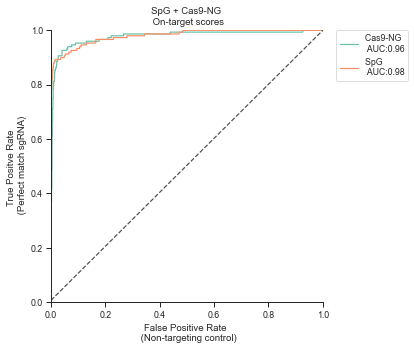

In [91]:
gpp.set_aesthetics(context='paper')
fig, ax = plt.subplots()
ax.plot(ng_roc.False_Positive_Rate, ng_roc.True_Positive_Rate, label='Cas9-NG \n AUC:0.96', color = '#66c2a5')
ax.plot(spg_roc.False_Positive_Rate, spg_roc.True_Positive_Rate, label='SpG \n AUC:0.98', color ='#fc8d62')
# ax.plot(intermediate_cbe_roc.False_Positive_Rate, intermediate_cbe_roc.True_Positive_Rate, label='Intermediate \n AUC:0.67, n = 119', 
# color = '#8da0cb')
# ax.plot(remaining_cbe_roc.False_Positive_Rate, remaining_cbe_roc.True_Positive_Rate, label='Remaining \n AUC:0.58, n = 166', color = '#e78ac3')
ax.legend(facecolor='white', loc='lower left')
ax.set_aspect('equal')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel('False Positive Rate \n (Non-targeting control)')
plt.ylabel('True Positve Rate \n (Perfect match sgRNA)')
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 1.0)
plt.title ('SpG + Cas9-NG \n On-target scores')
plt.xlim(0,1)
sns.despine()
#plt.savefig('ROC_AUC_SpG_NG.pdf', dpi=1000, bbox_inches='tight', transparent=True)


## Off-targets 

### Single mismatches 

In [92]:
perfect_single = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'single')]

In [93]:
perfect_single['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_single.iterrows()]
perfect_single['non-ess-val'] = [1 if r['Number of mismatches'] == 'single' else 0 for i,r in perfect_single.iterrows()]

In [94]:
ng_single_auc, ng_single_roc = get_roc_auc(perfect_single, 'NG avg_lfc')
ng_single_auc

0.8561903970999764

In [95]:
spg_single_auc, spg_single_roc = get_roc_auc(perfect_single, 'SpG avg_lfc')
spg_single_auc

0.855191571158539

## Double mismatches 

In [96]:
perfect_double = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'double')]

In [97]:
perfect_double['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_double.iterrows()]
perfect_double['non-ess-val'] = [1 if r['Number of mismatches'] == 'double' else 0 for i,r in perfect_double.iterrows()]

In [98]:
ng_double_auc, ng_double_roc = get_roc_auc(perfect_double, 'NG avg_lfc')
ng_double_auc

0.9653860469985103

In [99]:
spg_double_auc, spg_double_roc = get_roc_auc(perfect_double, 'SpG avg_lfc')
spg_double_auc

0.9704445946501461

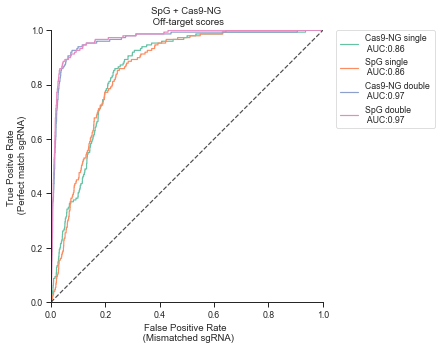

In [100]:
gpp.set_aesthetics(context='paper')
fig, ax = plt.subplots()
ax.plot(ng_single_roc.False_Positive_Rate, ng_single_roc.True_Positive_Rate, label='Cas9-NG single\n AUC:0.86', color = '#66c2a5')
ax.plot(spg_single_roc.False_Positive_Rate, spg_single_roc.True_Positive_Rate, label='SpG single \n AUC:0.86', color ='#fc8d62')
ax.plot(ng_double_roc.False_Positive_Rate, ng_double_roc.True_Positive_Rate, label='Cas9-NG double \n AUC:0.97', color = '#8da0cb')
ax.plot(spg_double_roc.False_Positive_Rate, spg_double_roc.True_Positive_Rate, label='SpG double \n AUC:0.97', color = '#e78ac3')
ax.legend(facecolor='white', loc='lower left')
ax.set_aspect('equal')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel('False Positive Rate \n (Mismatched sgRNA)')
plt.ylabel('True Positve Rate \n (Perfect match sgRNA)')
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 1.0)
plt.title ('SpG + Cas9-NG \n Off-target scores')
plt.xlim(0,1)
sns.despine()
#plt.savefig('ROC_AUC_SpG_NG_off-targets.pdf', dpi=1000, bbox_inches='tight', transparent=True)


Plot on and off-targets on the same plot

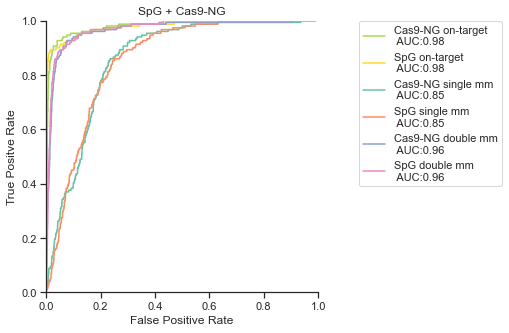

In [101]:
gpp.set_aesthetics(context='notebook')
fig, ax = plt.subplots()
ax.plot(ng_roc.False_Positive_Rate, ng_roc.True_Positive_Rate, label='Cas9-NG on-target\n AUC:0.98', color = '#a6d854')
ax.plot(spg_roc.False_Positive_Rate, spg_roc.True_Positive_Rate, label='SpG on-target \n AUC:0.98', color ='#ffd92f')
ax.plot(ng_single_roc.False_Positive_Rate, ng_single_roc.True_Positive_Rate, label='Cas9-NG single mm \n AUC:0.85', color = '#66c2a5')
ax.plot(spg_single_roc.False_Positive_Rate, spg_single_roc.True_Positive_Rate, label='SpG single mm \n AUC:0.85', color ='#fc8d62')
ax.plot(ng_double_roc.False_Positive_Rate, ng_double_roc.True_Positive_Rate, label='Cas9-NG double mm\n AUC:0.96', color = '#8da0cb')
ax.plot(spg_double_roc.False_Positive_Rate, spg_double_roc.True_Positive_Rate, label='SpG double mm \n AUC:0.96', color = '#e78ac3')
ax.legend(facecolor='white', loc='lower left')
ax.set_aspect('equal')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="1")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
ax.legend(facecolor='white', bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 1.0)
plt.title ('SpG + Cas9-NG')
plt.xlim(0,1)
sns.despine()
#plt.savefig('figures/ROC_AUC_SpG_NG_all.pdf', dpi=1000, bbox_inches='tight', transparent=True)
